In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
import os
import gc
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import random
import warnings
warnings.simplefilter('ignore')
OriginDataDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Data/OriginData'
CleanDataDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Data/CleanData'
TrainTestDataDir = '/home/songyue/homeCredit/HomeCreditDefaultRisk/Data/TrainTestData'
ModelSaveDir = 'models'
ResultSaveDir = 'result'

/usr/share/anaconda2/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/share/anaconda2/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/share/anaconda2/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/share/anaconda2/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/share/anaconda2/envs/py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/share

In [2]:
def loadData(DataName):
    DataPath = os.path.join(CleanDataDir, DataName)
    if not os.path.exists(DataPath):
        print('%s does not exist!' % DataPath)
        return
    OriginData = pd.read_csv(DataPath, index_col=0)
    #OriginData = OriginData.sample(frac=1)  # 打乱顺序后返回
    return OriginData

In [3]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('XGBOOST Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('XGBOOST_ImportantFeats.png')

In [4]:
X = loadData('Train.csv')

In [5]:
ObjectCol = X.select_dtypes(include=['object']).columns.tolist()
ObjectCol

['CODE_GENDER',
 'EMERGENCYSTATE_MODE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'NAME_CONTRACT_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'WALLSMATERIAL_MODE',
 'WEEKDAY_APPR_PROCESS_START']

In [6]:
X['credit_to_annuity_ratio'].head()

0    16.461104
1    36.234085
2    20.000000
3    10.532818
4    23.461618
Name: credit_to_annuity_ratio, dtype: float64

In [7]:
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,previous_application_prev_was_refused,previous_application_term_of_last_1_credits_mean,previous_application_days_decision_about_last_1_credits_mean,previous_application_days_first_drawing_last_1_credits_mean,previous_application_term_of_last_3_credits_mean,previous_application_days_decision_about_last_3_credits_mean,previous_application_days_first_drawing_last_3_credits_mean,previous_application_term_of_last_5_credits_mean,previous_application_days_decision_about_last_5_credits_mean,previous_application_days_first_drawing_last_5_credits_mean
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,24.0,-606.0,365243.0,24.0,-606.0,365243.0,24.0,-606.0,365243.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,-746.0,365243.0,10.0,-1305.0,365243.0,10.0,-1305.0,365243.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,-815.0,365243.0,4.0,-815.0,365243.0,4.0,-815.0,365243.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,48.0,-181.0,NaN,48.0,-181.0,NaN,24.0,-181.0,365243.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,24.0,-374.0,365243.0,30.0,-702.0,365243.0,22.8,-996.0,365243.0


In [8]:
X_null = X.isnull().sum().sort_values(ascending=False)/len(X)

In [9]:
X_null.head(10)

last_1_NUM_INSTALMENT_VERSION_std_x          1.000000
last_1_instalment_paid_over_amount_std_y     1.000000
last_1_instalment_paid_late_in_days_std_y    1.000000
last_1_NUM_INSTALMENT_VERSION_std_y          1.000000
last_1_instalment_paid_late_in_days_std_x    1.000000
last_1_instalment_paid_over_amount_std_x     1.000000
credit_card_avg_loading_of_credit_limit      0.819711
credit_card_cash_card_ratio                  0.802770
SK_ID_CURR_var_AMT_PAYMENT_CURRENT           0.799015
SK_ID_CURR_var_CNT_DRAWINGS_ATM_CURRENT      0.798762
dtype: float64

In [10]:
X_null_col = list(X_null[X_null == 1].index)
X_null_col

['last_1_NUM_INSTALMENT_VERSION_std_x',
 'last_1_instalment_paid_over_amount_std_y',
 'last_1_instalment_paid_late_in_days_std_y',
 'last_1_NUM_INSTALMENT_VERSION_std_y',
 'last_1_instalment_paid_late_in_days_std_x',
 'last_1_instalment_paid_over_amount_std_x']

In [11]:
#把缺失太多的去掉
X.drop(X_null_col,axis=1,inplace=True)

In [12]:
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,previous_application_prev_was_refused,previous_application_term_of_last_1_credits_mean,previous_application_days_decision_about_last_1_credits_mean,previous_application_days_first_drawing_last_1_credits_mean,previous_application_term_of_last_3_credits_mean,previous_application_days_decision_about_last_3_credits_mean,previous_application_days_first_drawing_last_3_credits_mean,previous_application_term_of_last_5_credits_mean,previous_application_days_decision_about_last_5_credits_mean,previous_application_days_first_drawing_last_5_credits_mean
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,24.0,-606.0,365243.0,24.0,-606.0,365243.0,24.0,-606.0,365243.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,-746.0,365243.0,10.0,-1305.0,365243.0,10.0,-1305.0,365243.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,-815.0,365243.0,4.0,-815.0,365243.0,4.0,-815.0,365243.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,48.0,-181.0,NaN,48.0,-181.0,NaN,24.0,-181.0,365243.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,24.0,-374.0,365243.0,30.0,-702.0,365243.0,22.8,-996.0,365243.0


In [12]:
#categoryFeats = X.select_dtypes(include=['object']).columns.tolist()
categoryFeats = ['CODE_GENDER',
                       'EMERGENCYSTATE_MODE',
                       'FLAG_CONT_MOBILE',
                       'FLAG_DOCUMENT_3',
                       'FLAG_DOCUMENT_4',
                       'FLAG_DOCUMENT_5',
                       'FLAG_DOCUMENT_6',
                       'FLAG_DOCUMENT_7',
                       'FLAG_DOCUMENT_8',
                       'FLAG_DOCUMENT_9',
                       'FLAG_DOCUMENT_11',
                       'FLAG_DOCUMENT_18',
                       'FLAG_EMAIL',
                       'FLAG_EMP_PHONE',
                       'FLAG_MOBIL',
                       'FLAG_OWN_CAR',
                       'FLAG_OWN_REALTY',
                       'FLAG_PHONE',
                       'FLAG_WORK_PHONE',
                       'FONDKAPREMONT_MODE',
                       'HOUR_APPR_PROCESS_START',
                       'HOUSETYPE_MODE',
                       'LIVE_CITY_NOT_WORK_CITY',
                       'LIVE_REGION_NOT_WORK_REGION',
                       'NAME_CONTRACT_TYPE',
                       'NAME_TYPE_SUITE',
                       'NAME_INCOME_TYPE',
                       'NAME_EDUCATION_TYPE',
                       'NAME_FAMILY_STATUS',
                       'NAME_HOUSING_TYPE',
                       'OCCUPATION_TYPE',
                       'ORGANIZATION_TYPE',
                       'REG_CITY_NOT_LIVE_CITY',
                       'REG_CITY_NOT_WORK_CITY',
                       'REG_REGION_NOT_LIVE_REGION',
                       'REG_REGION_NOT_WORK_REGION',
                       'WALLSMATERIAL_MODE',
                       'WEEKDAY_APPR_PROCESS_START']

In [13]:
for catname in ObjectCol:
    X[catname] = X[catname].astype('category')
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,previous_application_prev_was_refused,previous_application_term_of_last_1_credits_mean,previous_application_days_decision_about_last_1_credits_mean,previous_application_days_first_drawing_last_1_credits_mean,previous_application_term_of_last_3_credits_mean,previous_application_days_decision_about_last_3_credits_mean,previous_application_days_first_drawing_last_3_credits_mean,previous_application_term_of_last_5_credits_mean,previous_application_days_decision_about_last_5_credits_mean,previous_application_days_first_drawing_last_5_credits_mean
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,24.0,-606.0,365243.0,24.0,-606.0,365243.0,24.0,-606.0,365243.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,-746.0,365243.0,10.0,-1305.0,365243.0,10.0,-1305.0,365243.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,-815.0,365243.0,4.0,-815.0,365243.0,4.0,-815.0,365243.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,48.0,-181.0,NaN,48.0,-181.0,NaN,24.0,-181.0,365243.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,24.0,-374.0,365243.0,30.0,-702.0,365243.0,22.8,-996.0,365243.0


In [14]:
X[ObjectCol].head()

,CODE_GENDER,EMERGENCYSTATE_MODE,FLAG_OWN_CAR,FLAG_OWN_REALTY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START
0,M,No,N,Y,reg oper account,block of flats,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,Laborers,Business Entity Type 3,"Stone, brick",WEDNESDAY
1,F,No,N,N,reg oper account,block of flats,Cash loans,Higher education,Married,House / apartment,State servant,Family,Core staff,School,Block,MONDAY
2,M,NaN,Y,Y,NaN,NaN,Revolving loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,Laborers,Government,NaN,MONDAY
3,F,NaN,N,Y,NaN,NaN,Cash loans,Secondary / secondary special,Civil marriage,House / apartment,Working,Unaccompanied,Laborers,Business Entity Type 3,NaN,WEDNESDAY
4,M,NaN,N,Y,NaN,NaN,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,Core staff,Religion,NaN,THURSDAY


In [15]:
TestData = X[X.TARGET.isnull()]
TestData.reset_index(drop=True, inplace=True)
TestID = TestData.SK_ID_CURR.values
AllTrainData = X[~X.TARGET.isnull()]
AllTrainData.reset_index(drop=True, inplace=True)

In [16]:
AllTrainData.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,previous_application_prev_was_refused,previous_application_term_of_last_1_credits_mean,previous_application_days_decision_about_last_1_credits_mean,previous_application_days_first_drawing_last_1_credits_mean,previous_application_term_of_last_3_credits_mean,previous_application_days_decision_about_last_3_credits_mean,previous_application_days_first_drawing_last_3_credits_mean,previous_application_term_of_last_5_credits_mean,previous_application_days_decision_about_last_5_credits_mean,previous_application_days_first_drawing_last_5_credits_mean
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,24.0,-606.0,365243.0,24.0,-606.0,365243.0,24.0,-606.0,365243.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,-746.0,365243.0,10.0,-1305.0,365243.0,10.0,-1305.0,365243.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,-815.0,365243.0,4.0,-815.0,365243.0,4.0,-815.0,365243.0
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,48.0,-181.0,NaN,48.0,-181.0,NaN,24.0,-181.0,365243.0
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,24.0,-374.0,365243.0,30.0,-702.0,365243.0,22.8,-996.0,365243.0


In [17]:
AllTrainData.shape

(307511, 1088)

In [18]:
TestData.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,previous_application_prev_was_refused,previous_application_term_of_last_1_credits_mean,previous_application_days_decision_about_last_1_credits_mean,previous_application_days_first_drawing_last_1_credits_mean,previous_application_term_of_last_3_credits_mean,previous_application_days_decision_about_last_3_credits_mean,previous_application_days_first_drawing_last_3_credits_mean,previous_application_term_of_last_5_credits_mean,previous_application_days_decision_about_last_5_credits_mean,previous_application_days_first_drawing_last_5_credits_mean
0,20560.5,568800.0,450000.0,135000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,-1740.0,365243.0,8.0,-1740.000000,365243.0,8.000000,-1740.0,365243.000000
1,17370.0,222768.0,180000.0,99000.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,NaN,-315.0,NaN,12.0,-536.000000,365243.0,12.000000,-536.0,365243.000000
2,69777.0,663264.0,630000.0,202500.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0.0,NaN,-222.0,NaN,21.0,-450.333333,365243.0,17.333333,-837.5,365243.000000
3,49018.5,1575000.0,1575000.0,315000.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,NaN,-531.0,NaN,10.0,-775.333333,365243.0,11.333333,-1124.2,243054.333333
4,32067.0,625500.0,625500.0,180000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,36.0,-111.0,NaN,24.0,-466.000000,365243.0,24.000000,-466.0,365243.000000


In [19]:
TestData.shape

(48744, 1088)

In [20]:
features = [x for x in AllTrainData.columns if x != 'TARGET' and x != 'SK_ID_CURR' ]

In [21]:
len(features)

1086

In [22]:
clf = lgb.LGBMClassifier(  is_unbalance=False,
                               scale_pos_weight = 1,
                               reg_alpha=0.0,
                               reg_lambda= 150,
                               min_split_gain=0.5,
                               colsample_bytree=0.05,
                               subsample_freq=1,
                               subsample=1,
                               min_child_samples=70,
                               num_leaves=40,
                               max_depth=-1,
                               max_bin=300,
                               learning_rate=0.02,
                               n_estimators=10000,
                               boosting_type='gbdt',
                               application="binary",
                               num_threads = -1
                              )

In [23]:
df_train = AllTrainData
df_test = TestData
num_folds = 5
stratified = True
debug= False

In [54]:
# Divide in training/validation and test data
print("Starting LGBM. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=90210)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=90210)
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_train.shape[0])
sub_preds = np.zeros([df_test.shape[0],num_folds])
roc_score_list = []
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    model_config = {  #'random_search_runs': 0,
                      'device': 'gpu', # gpu cpu
                      'num_threads':-1,
                      'boosting_type': 'gbdt',
                      'objective': 'binary',
                      'metric': 'auc',
                      'learning_rate': 0.02,
                      'max_bin': 255,
                      'max_depth': -1,
                      'num_leaves': 40,
                      'min_child_samples': 40,
                      'subsample': 1.0,
                      'subsample_freq': 1,
                      'colsample_bytree': 0.05,
                      'min_gain_to_split': 0.5,
                      'reg_lambda': 120,
                      'reg_alpha': 0.0,
                      'scale_pos_weight': 1,
                      'is_unbalance': False}
    data_train = lgb.Dataset(data=train_x,label=train_y,feature_name='auto',categorical_feature='auto')
    data_valid = lgb.Dataset(data=valid_x,label=valid_y,feature_name='auto',categorical_feature='auto')
    clf = lgb.train( model_config,
                     data_train,
                     valid_sets=[data_train, data_valid],
                     valid_names=['data_train', 'data_valid'],
                     num_boost_round=5000,
                     early_stopping_rounds=100,
                     verbose_eval=200,
                     feature_name='auto',
                     categorical_feature='auto')
    
    oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration)
    sub_preds[:,n_fold]= clf.predict(df_test[features],num_iteration=clf.best_iteration)
    roc_curr = roc_auc_score(valid_y, oof_preds[valid_idx])
    roc_score_list.append(roc_curr)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr ))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting LGBM. Train shape: (307511, 1088), test shape: (48744, 1088)
Num of Feature: 1086
Training until validation scores don't improve for 100 rounds.
[200]	data_train's auc: 0.778138	data_valid's auc: 0.771458
[400]	data_train's auc: 0.801235	data_valid's auc: 0.785145
[600]	data_train's auc: 0.81592	data_valid's auc: 0.790693
[800]	data_train's auc: 0.8282	data_valid's auc: 0.794165
[1000]	data_train's auc: 0.838919	data_valid's auc: 0.796157
[1200]	data_train's auc: 0.848572	data_valid's auc: 0.797388
[1400]	data_train's auc: 0.8573	data_valid's auc: 0.798236
[1600]	data_train's auc: 0.865323	data_valid's auc: 0.798736
[1800]	data_train's auc: 0.872571	data_valid's auc: 0.799037
[2000]	data_train's auc: 0.879129	data_valid's auc: 0.799249
[2200]	data_train's auc: 0.885332	data_valid's auc: 0.799357
Early stopping, best iteration is:
[2245]	data_train's auc: 0.886612	data_valid's auc: 0.799411
Fold  1 AUC : 0.799411
Training until validation scores don't improve for 100 rounds.
[2

In [55]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50]
feats50 = list(cols.index)
feats50

['ORGANIZATION_TYPE',
 'credit_to_annuity_ratio',
 'payment_rate',
 'OCCUPATION_TYPE',
 'SK_ID_CURR_max_DAYS_CREDIT_ENDDATE',
 'DAYS_BIRTH',
 'SK_ID_CURR_max_DAYS_CREDIT',
 'EXT_SOURCE_3',
 'AMT_GOODS_PRICE',
 'OCCUPATION_TYPE_mean_DAYS_BIRTH_diff',
 'bureau_debt_credit_ratio',
 'SK_ID_CURR_max_AMT_CREDIT_SUM',
 'DAYS_LAST_PHONE_CHANGE',
 'REGION_POPULATION_RELATIVE',
 'phone_to_birth_ratio',
 'DAYS_EMPLOYED',
 'days_employed_percentage',
 'credit_to_goods_ratio',
 'SK_ID_CURR_max_DAYS_ENTRY_PAYMENT',
 'external_sources_nanmedian',
 'annuity_income_percentage',
 'OCCUPATION_TYPE_mean_AMT_ANNUITY_diff',
 'external_sources_min',
 'bureau_total_customer_credit',
 'AMT_ANNUITY',
 'SK_ID_CURR_mean_DAYS_CREDIT',
 'SK_ID_CURR_min_DAYS_CREDIT',
 'pos_cash_remaining_installments',
 'external_sources_sum',
 'EXT_SOURCE_2',
 'SK_ID_CURR_mean_AMT_CREDIT_SUM',
 'CODE_GENDER_REG_CITY_NOT_WORK_CITY_mean_DAYS_ID_PUBLISH_diff',
 'SK_ID_CURR_mean_DAYS_CREDIT_UPDATE',
 'phone_to_employ_ratio',
 'OCCUPATI

In [ ]:
df_train = AllTrainData
df_test = TestData
num_folds = 5
stratified = True
debug= False

In [24]:
# Divide in training/validation and test data
print("Starting LGBM. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=90210)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=90210)
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_train.shape[0])
sub_preds = np.zeros([df_test.shape[0],num_folds])
roc_score_list = []
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    clf = lgb.LGBMClassifier(  is_unbalance=False,
                               scale_pos_weight = 1,
                               reg_alpha= 0.0,
                               reg_lambda= 100,
                               min_split_gain=0.5,
                               colsample_bytree=0.05,
                               subsample_freq=1,
                               subsample=1.0,
                               min_child_samples=70,
                               num_leaves= 30,
                               max_depth=-1,
                               max_bin=300,
                               learning_rate=0.02,
                               boosting_type='gbdt',
                               application="binary",
                               num_threads = -1
                              )

    clf.fit(train_x, train_y, eval_metric='auc',
              eval_set=[(valid_x, valid_y), (train_x, train_y)],
              eval_names=['valid', 'train'], number_boosting_rounds = 5000,
            early_stopping_rounds=100, verbose=200)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds[:,n_fold]= clf.predict_proba(df_test[features], num_iteration=clf.best_iteration_)[:, 1] 
    roc_curr = roc_auc_score(valid_y, oof_preds[valid_idx])
    roc_score_list.append(roc_curr)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr ))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting LGBM. Train shape: (307511, 1088), test shape: (48744, 1088)
Num of Feature: 1086


TypeError: fit() got an unexpected keyword argument 'number_boosting_rounds'

In [56]:
print(np.mean(roc_score_list))

0.7942118279320288


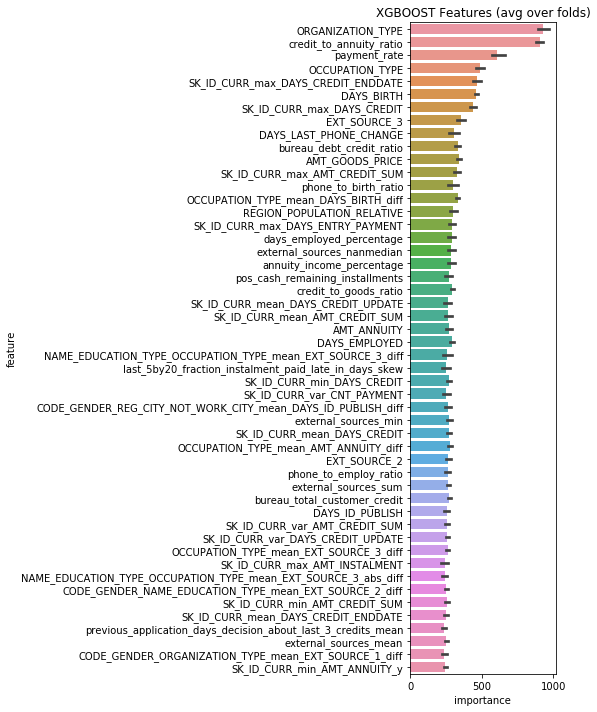

In [57]:
display_importances(feature_importance_df)

In [58]:
def calculate_rank(predictions):
    rank = (1 + predictions.rank().values) / (predictions.shape[0] + 1)
    return rank

In [59]:
subtmp = pd.DataFrame({'fold%d'%i:sub_preds[:,i] for i in range(sub_preds.shape[1])})
subtmp.head()

,fold0,fold1,fold2,fold3,fold4
0,0.040868,0.041194,0.026927,0.031098,0.036532
1,0.117642,0.132376,0.150874,0.143282,0.145175
2,0.047810,0.032412,0.044329,0.033396,0.038987
3,0.042526,0.045399,0.042392,0.048903,0.040116
4,0.152172,0.153351,0.160671,0.169571,0.156736


In [60]:
pred = []
for i in range(subtmp.shape[1]):
    pred.append(calculate_rank(subtmp['fold%d'%i]))
pred

[array([0.47924915, 0.81721202, 0.53632167, ..., 0.05641604, 0.25518515,
        0.898964  ]),
 array([0.48312647, 0.84295825, 0.39803057, ..., 0.03464971, 0.23253667,
        0.91484255]),
 array([0.33478305, 0.87108421, 0.51047287, ..., 0.06078572, 0.2005539 ,
        0.92194071]),
 array([0.38810134, 0.86453995, 0.41409375, ..., 0.05504154, 0.20008206,
        0.92159196]),
 array([0.44743051, 0.86252949, 0.46987383, ..., 0.05694943, 0.2156734 ,
        0.88597805])]

In [61]:
submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': np.mean(pred,axis=0)})
submission.to_csv("lgbm_open_lucky.csv", index=False)

In [62]:
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.426538
1,100005,0.851665
2,100013,0.465759
3,100028,0.508906
4,100038,0.880858


In [20]:
df_train = AllTrainData
df_test = TestData
num_folds = 10
stratified = True
debug= False

In [40]:
# Divide in training/validation and test data
print("Starting LGBM. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1054)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1054)
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_train.shape[0])
sub_preds = np.zeros(df_test.shape[0])
roc_score_list = []
bestModel = None
bestRoc = None
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    if n_fold!=0:
        break
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    clf = lgb.LGBMClassifier(is_unbalance=False,
                               scale_pos_weight = 2,
                               reg_alpha=0.0,
                               reg_lambda=90,
                               min_split_gain=0.5,
                               colsample_bytree=0.05,
                               subsample_freq=1,
                               subsample=1,
                               min_child_samples=70,
                               num_leaves=34,
                               max_depth=-1,
                               max_bin=300,
                               learning_rate=0.02,
                               n_estimators=10000,
                               boosting_type='gbdt',
                               application="binary",
                               num_threads = -1
                              )

    clf.fit(train_x, train_y, eval_metric='auc',
              eval_set=[(valid_x, valid_y), (train_x, train_y)],
              eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=200)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds = clf.predict_proba(df_test[features], num_iteration=clf.best_iteration_)[:, 1] 
    roc_curr = roc_auc_score(valid_y, oof_preds[valid_idx])
    roc_score_list.append(roc_curr)
    if bestRoc is None or roc_curr>bestRoc:
        bestRoc = roc_curr
        bestModel = clf
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr ))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting LGBM. Train shape: (307511, 1099), test shape: (48744, 1098)
Num of Feature: 1083
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.788275	valid's auc: 0.771996
[400]	train's auc: 0.806533	valid's auc: 0.782915
[600]	train's auc: 0.820113	valid's auc: 0.788594
[800]	train's auc: 0.83118	valid's auc: 0.791878
[1000]	train's auc: 0.840819	valid's auc: 0.793993
[1200]	train's auc: 0.84951	valid's auc: 0.795149
[1400]	train's auc: 0.857187	valid's auc: 0.796227
[1600]	train's auc: 0.864426	valid's auc: 0.796873
[1800]	train's auc: 0.871054	valid's auc: 0.797249
[2000]	train's auc: 0.877101	valid's auc: 0.797502
[2200]	train's auc: 0.882725	valid's auc: 0.797484
Early stopping, best iteration is:
[2135]	train's auc: 0.880945	valid's auc: 0.79756
Fold  1 AUC : 0.797560


In [41]:
sub_preds

array([0.07623123, 0.21191958, 0.07922843, ..., 0.0152783 , 0.04383713,
       0.30151095])

In [44]:
submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': sub_preds})
submission.to_csv("lgbm_test0735.csv", index=False)

In [43]:
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.076231
1,100005,0.211920
2,100013,0.079228
3,100028,0.075134
4,100038,0.219361


In [36]:
# Divide in training/validation and test data
print("Starting LGBM. Train shape: {}, test shape: {}".format(df_train.shape, df_test.shape))
print("Num of Feature:",len(features))
# Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=90210)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=90210)
# Create arrays and dataframes to store results
oof_preds = np.zeros(df_train.shape[0])
sub_preds = np.zeros(df_test.shape[0])
roc_score_list = []
feature_importance_df = pd.DataFrame()
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train['TARGET'])):
    train_x, train_y = df_train[features].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
    valid_x, valid_y = df_train[features].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

    clf = lgb.LGBMClassifier(
            nthread=-1,
            #is_unbalance=True,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            scale_pos_weight=2.5
            )

    clf.fit(train_x, train_y, eval_metric='auc',
              eval_set=[(valid_x, valid_y), (train_x, train_y)],
              eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=200)
    
    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds = clf.predict_proba(df_test[features], num_iteration=clf.best_iteration_)[:, 1] 
    roc_curr = roc_auc_score(valid_y, oof_preds[valid_idx])
    roc_score_list.append(roc_curr)
    if bestRoc is None or roc_curr>bestRoc:
        bestRoc = roc_curr
        bestModel = clf
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_curr ))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting LGBM. Train shape: (307511, 1515), test shape: (48744, 1515)
Num of Feature: 1513
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.797799	valid's auc: 0.773177
[400]	train's auc: 0.828938	valid's auc: 0.783686
[600]	train's auc: 0.851181	valid's auc: 0.786909
[800]	train's auc: 0.868797	valid's auc: 0.788129
[1000]	train's auc: 0.883949	valid's auc: 0.788648
Early stopping, best iteration is:
[999]	train's auc: 0.883875	valid's auc: 0.788673
Fold  1 AUC : 0.788673


In [47]:
submission = pd.DataFrame({'SK_ID_CURR': TestID, 'TARGET': sub_preds})
submission.to_csv("lgbm_test0736.csv", index=False)